In [536]:
import os
import getpass
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
warnings.filterwarnings('ignore')

from datetime import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pycountry_convert as pc
import pycountry
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import pickle
from datetime import datetime
from sklearn.metrics import mean_squared_log_error
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from IPython.core.display import clear_output
from IPython.display import Image  
from math import sqrt
from matplotlib.pylab import rcParams
from pandas import DataFrame
from pmdarima.model_selection import train_test_split
from pprint import pprint
from pylab import rcParams
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals.six import StringIO  
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from statistics import mean
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from subprocess import call
from termcolor import colored
from time import sleep
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import trange, tqdm, tnrange
from xgboost import plot_importance, plot_tree, XGBClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
import graphviz
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima.arima import auto_arima, ARIMA
import pydotplus
import pyodbc 
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.api as sm
import warnings
import xgboost as xgb

## Data load

In [342]:
url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
df = pd.read_csv(url,index_col=0)
df.head(5)

,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
Date,,,,,,,
2020-01-22,Afghanistan,NaN,33.0,65.0,0,0.0,0
2020-01-23,Afghanistan,NaN,33.0,65.0,0,0.0,0
2020-01-24,Afghanistan,NaN,33.0,65.0,0,0.0,0
2020-01-25,Afghanistan,NaN,33.0,65.0,0,0.0,0
2020-01-26,Afghanistan,NaN,33.0,65.0,0,0.0,0


In [343]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 16434 entries, 2020-01-22 to 2020-03-27
Data columns (total 7 columns):
Country/Region    16434 non-null object
Province/State    5016 non-null object
Lat               16434 non-null float64
Long              16434 non-null float64
Confirmed         16434 non-null int64
Recovered         15444 non-null float64
Deaths            16434 non-null int64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.0+ MB


In [344]:
df = df.rename(columns={'Province/State': 'Province', 'Country/Region': 'Country'})
df.shape

(16434, 7)

In [345]:
df['Province_and_country'] = df['Country'].map(str) + "_" + df['Province'].map(str)
df['Province_and_country'] = df['Province_and_country'].str.replace('_nan', '').map(str)

In [346]:
df['Days_since_outbreak_global'] = df.groupby(['Province_and_country','Lat','Long']).cumcount()+1

In [347]:
df.head()

,Country,Province,Lat,Long,Confirmed,Recovered,Deaths,Province_and_country,Days_since_outbreak_global
Date,,,,,,,,,
2020-01-22,Afghanistan,NaN,33.0,65.0,0,0.0,0,Afghanistan,1
2020-01-23,Afghanistan,NaN,33.0,65.0,0,0.0,0,Afghanistan,2
2020-01-24,Afghanistan,NaN,33.0,65.0,0,0.0,0,Afghanistan,3
2020-01-25,Afghanistan,NaN,33.0,65.0,0,0.0,0,Afghanistan,4
2020-01-26,Afghanistan,NaN,33.0,65.0,0,0.0,0,Afghanistan,5


In [348]:
df.to_csv('df_m.CSV',sep=',')

## Analysis - Amount of cases

In [349]:
len(df['Province_and_country'].unique())

249

In [350]:
len(df['Country'].unique())

176

In [351]:
len(df['Province'].unique())

77

In [352]:
df.describe()

,Lat,Long,Confirmed,Recovered,Deaths,Days_since_outbreak_global
count,16434.000000,16434.000000,16434.000000,15444.000000,16434.000000,16434.000000
mean,22.272430,24.439131,461.464038,159.004727,17.629974,33.500000
std,24.508295,71.235138,4320.464950,2245.904617,230.168529,19.050951
min,-41.454500,-135.000000,0.000000,0.000000,0.000000,1.000000
25%,8.538000,-15.180400,0.000000,0.000000,0.000000,17.000000
50%,24.000000,21.005900,0.000000,0.000000,0.000000,33.500000
75%,41.377500,88.092400,22.000000,1.000000,0.000000,50.000000
max,71.706900,178.065000,101657.000000,61732.000000,9134.000000,66.000000


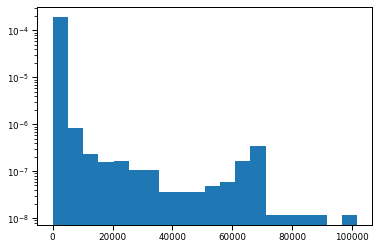

In [353]:
plt.hist(df['Confirmed'], density=True, bins=20) 
plt.yscale('log')

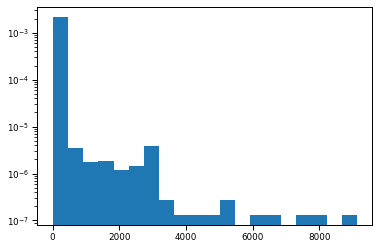

In [354]:
plt.hist(df['Deaths'], density=True, bins=20) 
plt.yscale('log')

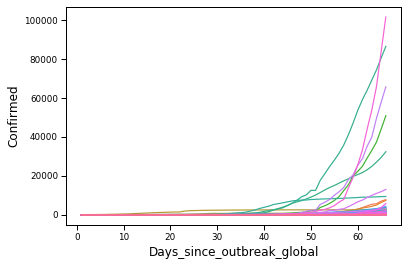

In [355]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Confirmed", ci=None)
ax.legend_.remove()

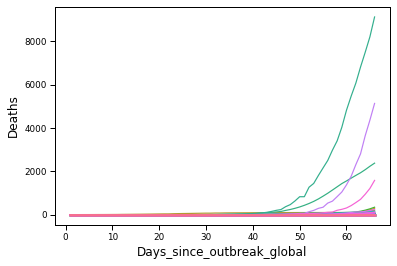

In [356]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Deaths", ci=None)
ax.legend_.remove()

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...  57  \
Country                                                             ...       
Afghanistan                  0   0   0   0   0   0   0   0   0   0  ...  22   
Albania                      0   0   0   0   0   0   0   0   0   0  ...  59   
Algeria                      0   0   0   0   0   0   0   0   0   0  ...  74   
Andorra                      0   0   0   0   0   0   0   0   0   0  ...  39   
Angola                       0   0   0   0   0   0   0   0   0   0  ...   0   

Days_since_outbreak_global  58  59   60   61   62   63   64   65   66  
Country                                                                
Afghanistan                 22  24   24   40   40   74   84   94  110  
Albania                     64  70   76   89  104  123  146  174  186  
Algeria                     87  90  139  201  230  264  302  367  409  
Andorra                     53  75   88  113  133  164  188  224  267  
Angola        

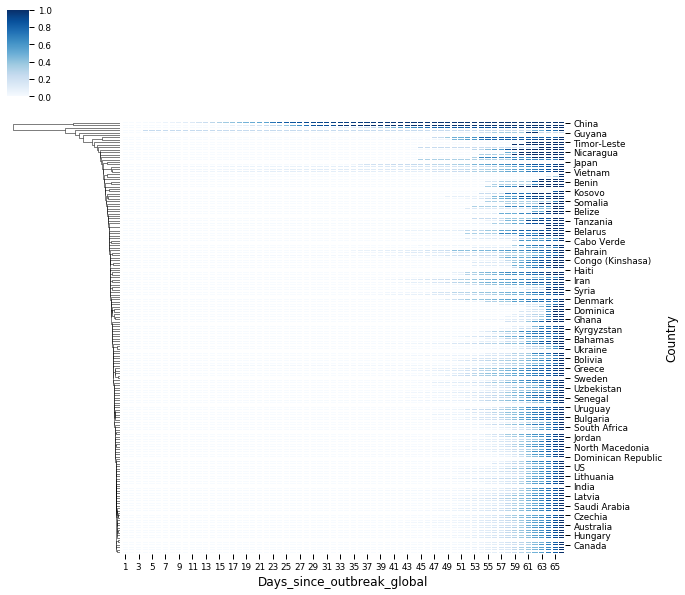

<Figure size 1800x576 with 0 Axes>

In [357]:
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":12,"axes.labelsize":12})   
def group_and_chart(Geography, Figure, Data):
    grouped = Data.groupby(['Days_since_outbreak_global',Geography])[Figure].sum()
    grouped= pd.DataFrame(grouped) 
    grouped.reset_index(inplace=True)
    grouped=grouped.pivot(index='Days_since_outbreak_global', columns=Geography, values=Figure)
    grouped = grouped.T[(grouped != 0).any()].T
    grouped = grouped.transpose()
    grouped.fillna(0, inplace=True)
    print(grouped.head())
    sns.clustermap(grouped, cmap="Blues", linewidth=.5, standard_scale=0,  col_cluster=False, method='single')
    plt.figure(figsize=(25,8))
    
group_and_chart(Geography='Country', Figure='Confirmed', Data=df)

In [358]:
# function for getting the iso code through fuzzy search
def do_fuzzy_search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_2

# manually change name of some countries
df.loc[df['Country'] == 'Korea, South', 'Country'] = 'Korea, Republic of'
df.loc[df['Country'] == 'Taiwan*', 'Country'] = 'Taiwan'
df.loc[df['Country'] == 'Burma', 'Country'] = 'Myanmar'
df.loc[df['Country'] == 'Holy See', 'Country'] = 'Italy'
df.loc[df['Country'] == 'Laos', 'Country'] = "Lao"
df.loc[df['Country'] == "Congo (Kinshasa)", 'Country'] = "Congo"
df.loc[df['Country'] == "Congo (Brazzaville)", 'Country'] = "Congo"
df.loc[df['Country'] == "West Bank and Gaza", 'Country'] = "Palestine"

# create iso mapping for countries in df
iso_map = {country: do_fuzzy_search(country) for country in df['Country'].unique()}
# apply the mapping to df
df['iso'] = df['Country'].map(iso_map)

In [359]:
def alpha2_to_continent(iso):
    try: cont = pc.country_alpha2_to_continent_code(iso)
    except: cont = float('NaN')
    return cont

df['Continent'] = df['iso'].apply(alpha2_to_continent) # get continent code

df.loc[df['Country'] == "Congo", 'Continent'] = "AF"
df.loc[df['Country'] == 'Timor-Leste', 'Continent'] = 'AS'
df.loc[df['Country'] == 'Diamond Princess', 'Continent'] = 'Diamond Princess'

df['Continent'] = df['Continent'].map({'Diamond Princess':'Diamond Princess','AF':'Africa','AS':'Asia','EU':'Europe','NA':'North America','OC':'Oceania','SA':'South America'})

Days_since_outbreak_global   1    2    3     4     5     6     7     8     9   \
Continent                                                                       
Africa                        0    0    0     0     0     0     0     0     0   
Asia                        554  653  937  1429  2105  2912  5558  6143  8208   
Diamond Princess              0    0    0     0     0     0     0     0     0   
Europe                        0    0    2     3     3     4     8    10    10   
North America                 1    1    2     2     6     6     7     7     7   

Days_since_outbreak_global    10  ...      57      58      59      60      61  \
Continent                         ...                                           
Africa                         0  ...     601     781     969    1172    1437   
Asia                        9889  ...  112567  114935  117299  120030  123216   
Diamond Princess               0  ...     712     712     712     712     712   
Europe                     

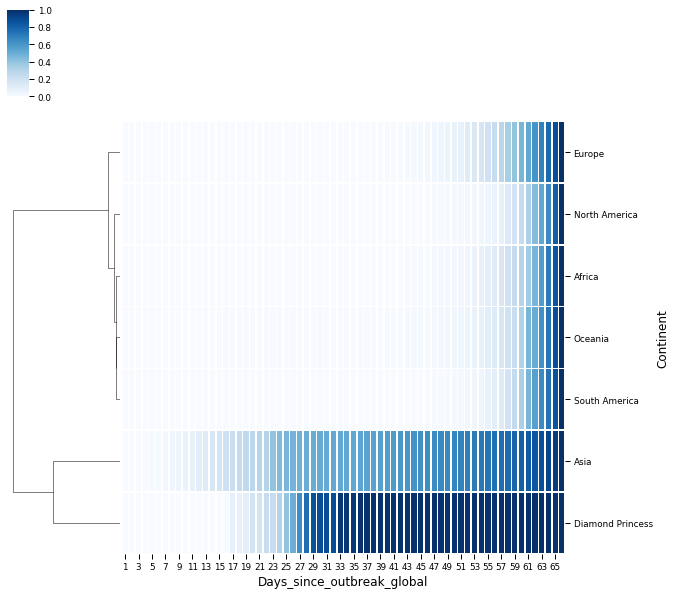

<Figure size 1800x576 with 0 Axes>

In [360]:
group_and_chart(Geography='Continent', Figure='Confirmed', Data=df)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   57  \
Country                                                             ...        
Afghanistan                  0   0   0   0   0   0   0   0   0   0  ...   22   
Armenia                      0   0   0   0   0   0   0   0   0   0  ...   84   
Azerbaijan                   0   0   0   0   0   0   0   0   0   0  ...   28   
Bahrain                      0   0   0   0   0   0   0   0   0   0  ...  256   
Bangladesh                   0   0   0   0   0   0   0   0   0   0  ...   14   

Days_since_outbreak_global   58   59   60   61   62   63   64   65   66  
Country                                                                  
Afghanistan                  22   24   24   40   40   74   84   94  110  
Armenia                     115  136  160  194  235  249  265  290  329  
Azerbaijan                   44   44   53   65   72   87   93  122  165  
Bahrain                     278  285  305  334  377  392  419  458  4

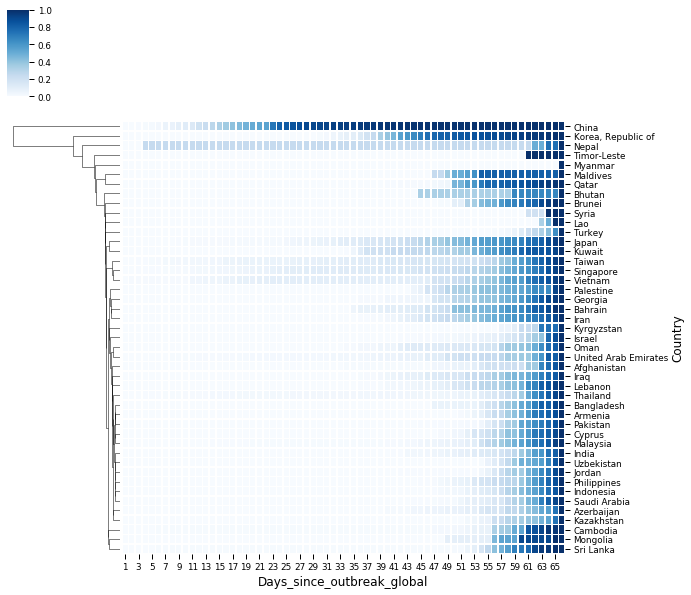

<Figure size 1800x576 with 0 Axes>

In [361]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...    57  \
Country                                                             ...         
Albania                      0   0   0   0   0   0   0   0   0   0  ...    59   
Andorra                      0   0   0   0   0   0   0   0   0   0  ...    39   
Austria                      0   0   0   0   0   0   0   0   0   0  ...  1646   
Belarus                      0   0   0   0   0   0   0   0   0   0  ...    51   
Belgium                      0   0   0   0   0   0   0   0   0   0  ...  1486   

Days_since_outbreak_global    58    59    60    61    62    63    64    65  \
Country                                                                      
Albania                       64    70    76    89   104   123   146   174   
Andorra                       53    75    88   113   133   164   188   224   
Austria                     2013  2388  2814  3582  4474  5283  5588  6909   
Belarus                       51    69    

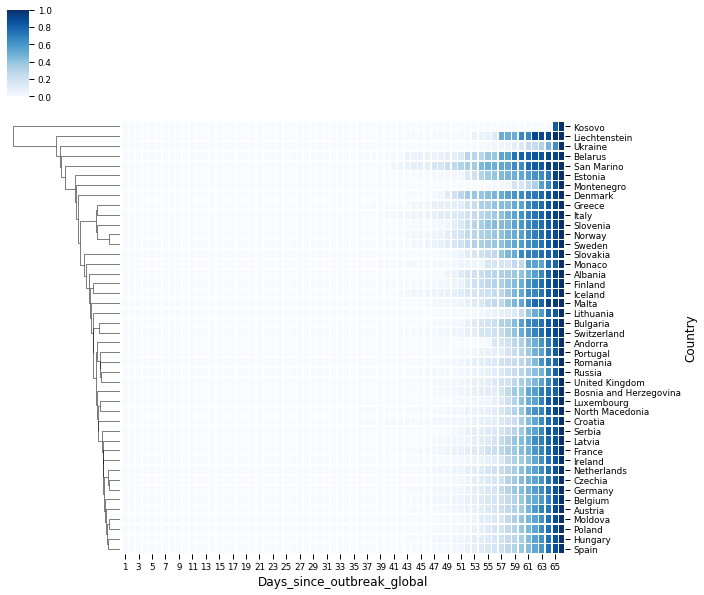

<Figure size 1800x576 with 0 Axes>

In [362]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...  57  \
Country                                                             ...       
Algeria                      0   0   0   0   0   0   0   0   0   0  ...  74   
Angola                       0   0   0   0   0   0   0   0   0   0  ...   0   
Benin                        0   0   0   0   0   0   0   0   0   0  ...   2   
Burkina Faso                 0   0   0   0   0   0   0   0   0   0  ...  20   
Cabo Verde                   0   0   0   0   0   0   0   0   0   0  ...   0   

Days_since_outbreak_global  58  59   60   61   62   63   64   65   66  
Country                                                                
Algeria                     87  90  139  201  230  264  302  367  409  
Angola                       0   1    2    2    3    3    3    4    4  
Benin                        2   2    2    2    5    6    6    6    6  
Burkina Faso                33  40   64   75   99  114  146  152  180  
Cabo Verde    

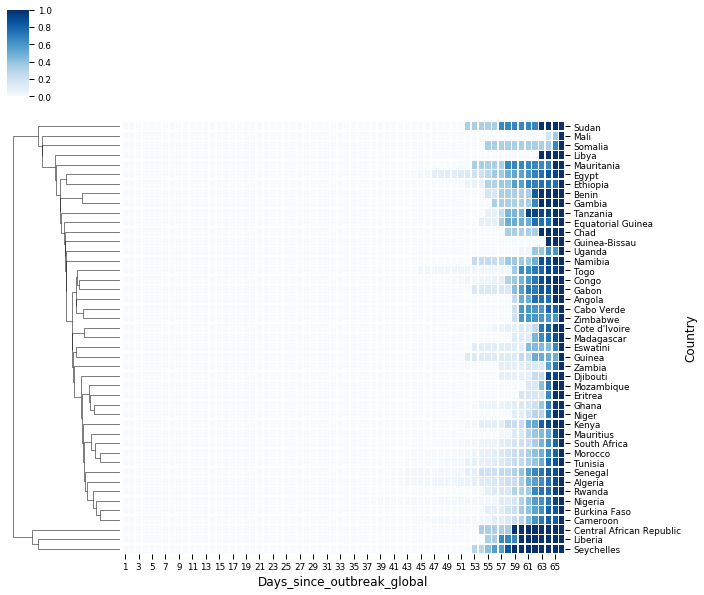

<Figure size 1800x576 with 0 Axes>

In [363]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   57  \
Country                                                             ...        
Antigua and Barbuda          0   0   0   0   0   0   0   0   0   0  ...    1   
Bahamas                      0   0   0   0   0   0   0   0   0   0  ...    1   
Barbados                     0   0   0   0   0   0   0   0   0   0  ...    2   
Belize                       0   0   0   0   0   0   0   0   0   0  ...    0   
Canada                       0   0   0   0   1   1   2   2   2   4  ...  657   

Days_since_outbreak_global   58   59    60    61    62    63    64    65    66  
Country                                                                         
Antigua and Barbuda           1    1     1     1     3     3     3     7     7  
Bahamas                       3    3     4     4     4     5     5     9    10  
Barbados                      5    5     6    14    17    18    18    18    24  
Belize                        0   

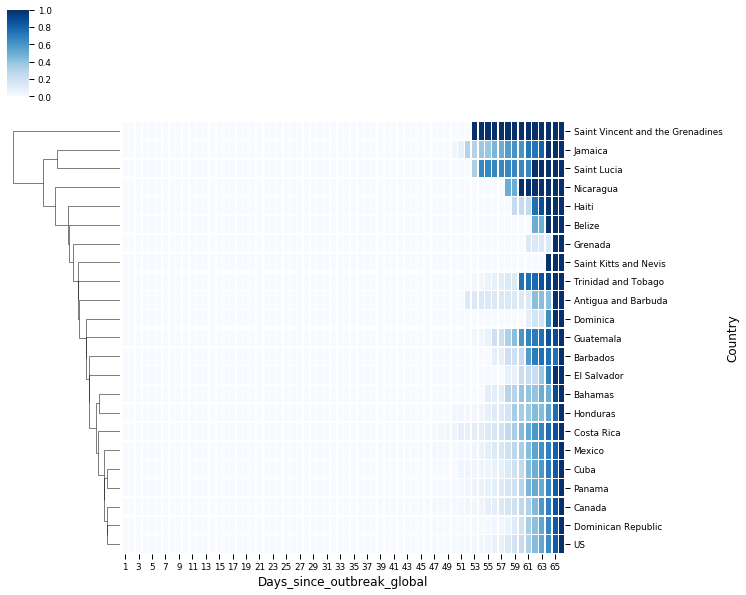

<Figure size 1800x576 with 0 Axes>

In [364]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   57  \
Country                                                             ...        
Australia                    0   0   0   0   4   5   5   6   9   9  ...  568   
Fiji                         0   0   0   0   0   0   0   0   0   0  ...    0   
New Zealand                  0   0   0   0   0   0   0   0   0   0  ...   20   
Papua New Guinea             0   0   0   0   0   0   0   0   0   0  ...    0   

Days_since_outbreak_global   58   59    60    61    62    63    64    65    66  
Country                                                                         
Australia                   681  791  1071  1549  1682  2044  2364  2810  3143  
Fiji                          1    1     1     2     3     4     5     5     5  
New Zealand                  28   39    52   102   102   155   205   283   368  
Papua New Guinea              0    1     1     1     1     1     1     1     1  

[4 rows x 66 columns]


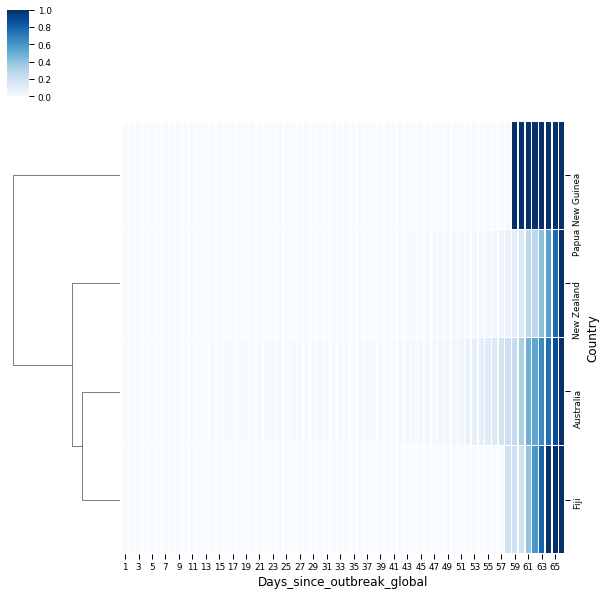

<Figure size 1800x576 with 0 Axes>

In [365]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   57  \
Country                                                             ...        
Argentina                    0   0   0   0   0   0   0   0   0   0  ...   79   
Bolivia                      0   0   0   0   0   0   0   0   0   0  ...   12   
Brazil                       0   0   0   0   0   0   0   0   0   0  ...  372   
Chile                        0   0   0   0   0   0   0   0   0   0  ...  238   
Colombia                     0   0   0   0   0   0   0   0   0   0  ...   93   

Days_since_outbreak_global   58   59    60    61    62    63    64    65    66  
Country                                                                         
Argentina                    97  128   158   266   301   387   387   502   589  
Bolivia                      12   15    19    24    27    29    32    43    61  
Brazil                      621  793  1021  1546  1924  2247  2554  2985  3417  
Chile                       238  4

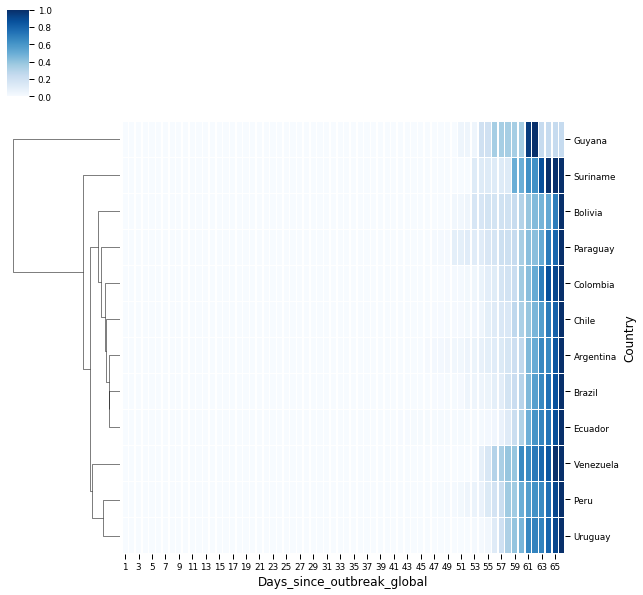

<Figure size 1800x576 with 0 Axes>

In [366]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

## Analysis - daily increase

In [367]:
df['Date'] = df.index
df = df.reset_index(drop = True)
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week_number'] = df['Date'].dt.week
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Confirmed_lag_1'] = df.groupby('Province_and_country')['Confirmed'].shift(1)
df['Daily_increase_confirmed'] = (df['Confirmed']/df['Confirmed_lag_1'])-1
df['Deaths_lag_1'] = df.groupby('Province_and_country')['Deaths'].shift(1)
df['Daily_increase_death'] = (df['Deaths']/df['Deaths_lag_1'])-1
df = df.replace([np.inf, -np.inf], np.nan)
#df.loc[df['Daily_increase_confirmed'] == np.inf, 'Daily_increase_confirmed'] = df['Confirmed']
#df.loc[df['Daily_increase_death'] == np.inf, 'Daily_increase_death'] = df['Deaths']
df = df.replace(np.nan, 0)
df

,Country,Province,Lat,Long,Confirmed,Recovered,Deaths,Province_and_country,Days_since_outbreak_global,iso,...,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_1,Daily_increase_confirmed,Deaths_lag_1,Daily_increase_death
0,Afghanistan,0,33.0000,65.000,0,0.0,0,Afghanistan,1,AF,...,22,2,4,1,1,2020,0.0,0.0,0.0,0.0
1,Afghanistan,0,33.0000,65.000,0,0.0,0,Afghanistan,2,AF,...,23,3,4,1,1,2020,0.0,0.0,0.0,0.0
2,Afghanistan,0,33.0000,65.000,0,0.0,0,Afghanistan,3,AF,...,24,4,4,1,1,2020,0.0,0.0,0.0,0.0
3,Afghanistan,0,33.0000,65.000,0,0.0,0,Afghanistan,4,AF,...,25,5,4,1,1,2020,0.0,0.0,0.0,0.0
4,Afghanistan,0,33.0000,65.000,0,0.0,0,Afghanistan,5,AF,...,26,6,4,1,1,2020,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16429,Myanmar,0,21.9162,95.956,0,0.0,0,Burma,62,MM,...,23,0,13,1,3,2020,0.0,0.0,0.0,0.0
16430,Myanmar,0,21.9162,95.956,0,0.0,0,Burma,63,MM,...,24,1,13,1,3,2020,0.0,0.0,0.0,0.0
16431,Myanmar,0,21.9162,95.956,0,0.0,0,Burma,64,MM,...,25,2,13,1,3,2020,0.0,0.0,0.0,0.0
16432,Myanmar,0,21.9162,95.956,0,0.0,0,Burma,65,MM,...,26,3,13,1,3,2020,0.0,0.0,0.0,0.0


In [368]:
df.to_csv('df_m.CSV',sep=',')

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Albania                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Algeria                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Andorra                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Angola                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...        57        58        59        60  \
Country                     ...                                           
Afghanistan                 ...  0.000000  0.000000  0.090909  0.000000   
Albania                     ...  0.072727  0.084746  0.093750  0.085714   
Algeria                     ...  0.233333  0.175676  0.034483  0.544444   
Andorra                     ...  0.000000  0.358974  0.415094  0

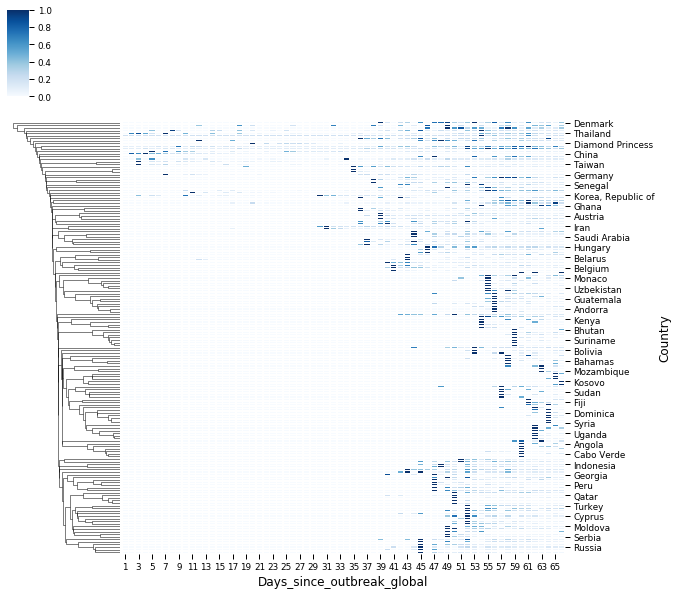

<Figure size 1800x576 with 0 Axes>

In [369]:
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1          2          3          4          5   \
Continent                                                                     
Africa                      0.0   0.000000   0.000000   0.000000   0.000000   
Asia                        0.0  32.879976  31.618121  39.505271  19.947801   
Diamond Princess            0.0   0.000000   0.000000   0.000000   0.000000   
Europe                      0.0   0.000000   0.000000   0.500000   0.000000   
North America               0.0   0.000000   1.000000   0.000000   1.500000   

Days_since_outbreak_global         6          7         8         9   \
Continent                                                              
Africa                       0.000000   0.000000  0.000000  0.000000   
Asia                        20.027021  15.679485  7.478922  9.050445   
Diamond Princess             0.000000   0.000000  0.000000  0.000000   
Europe                       0.000000   3.333333  0.250000  0.000000   
North America 

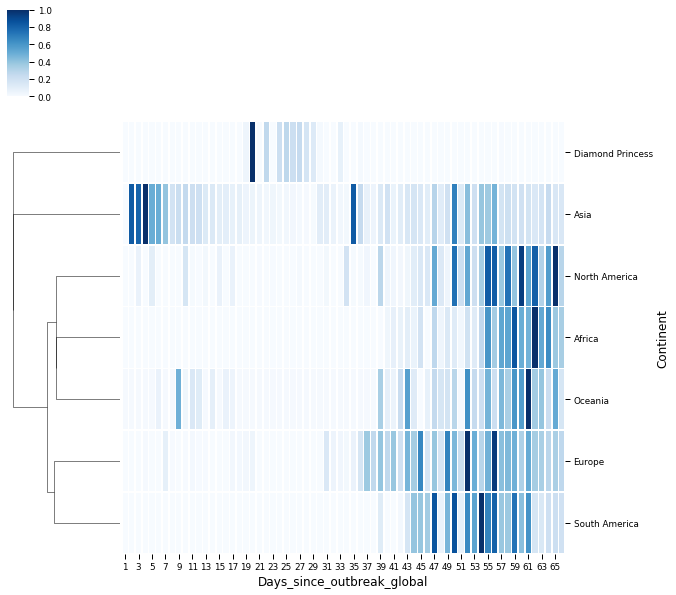

<Figure size 1800x576 with 0 Axes>

In [370]:
group_and_chart(Geography='Continent', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Armenia                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Azerbaijan                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bahrain                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bangladesh                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...        57        58        59        60  \
Country                     ...                                           
Afghanistan                 ...  0.000000  0.000000  0.090909  0.000000   
Armenia                     ...  0.076923  0.369048  0.182609  0.176471   
Azerbaijan                  ...  0.000000  0.571429  0.000000  0.204545   
Bahrain                     ...  0.122807  0.085938  0.025180  0

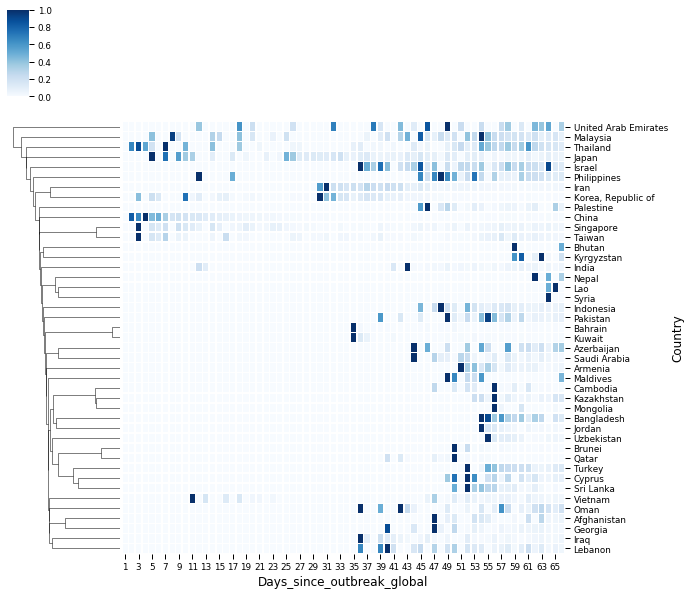

<Figure size 1800x576 with 0 Axes>

In [371]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Albania                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Andorra                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Austria                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Belarus                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Belgium                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...        57        58        59        60  \
Country                     ...                                           
Albania                     ...  0.072727  0.084746  0.093750  0.085714   
Andorra                     ...  0.000000  0.358974  0.415094  0.173333   
Austria                     ...  0.235736  0.222965  0.186289  0.178392   
Belarus                     ...  0.416667  0.000000  0.352941  0

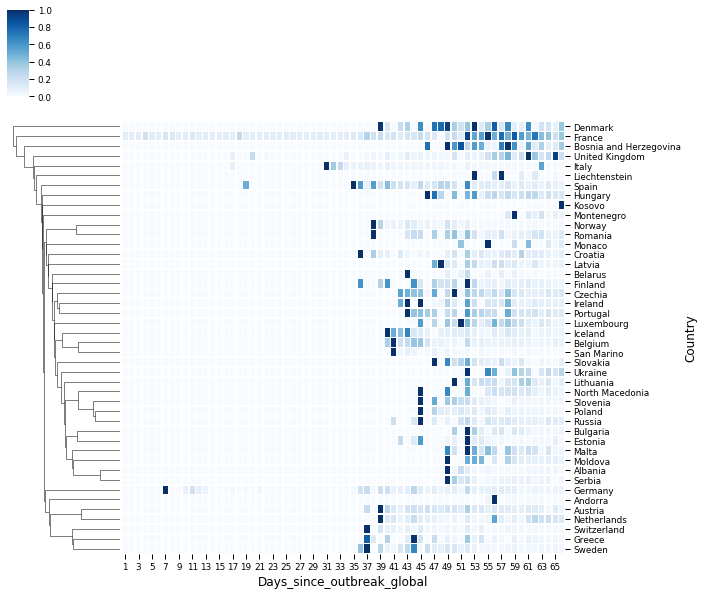

<Figure size 1800x576 with 0 Axes>

In [372]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Algeria                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Angola                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Benin                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Burkina Faso                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Cabo Verde                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...        57        58        59        60  \
Country                     ...                                           
Algeria                     ...  0.233333  0.175676  0.034483  0.544444   
Angola                      ...  0.000000  0.000000  0.000000  1.000000   
Benin                       ...  1.000000  0.000000  0.000000  0.000000   
Burkina Faso                ...  0.333333  0.650000  0.212121  0

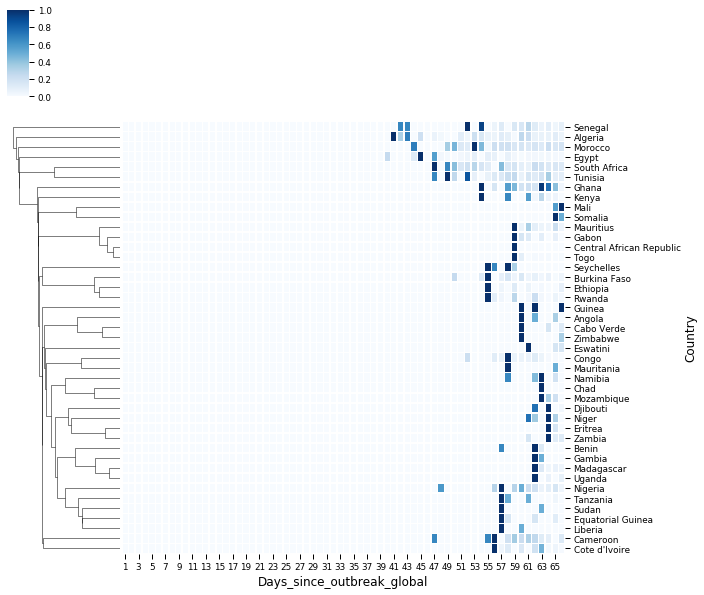

<Figure size 1800x576 with 0 Axes>

In [373]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Antigua and Barbuda         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bahamas                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Barbados                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Belize                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Canada                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0   

Days_since_outbreak_global  ...        57       58        59        60  \
Country                     ...                                          
Antigua and Barbuda         ...  0.000000  0.00000  0.000000  0.000000   
Bahamas                     ...  0.000000  2.00000  0.000000  0.333333   
Barbados                    ...  0.000000  1.50000  0.000000  0.200000   
Belize                      ...  0.000000  0.00000  0.000000  0.00000

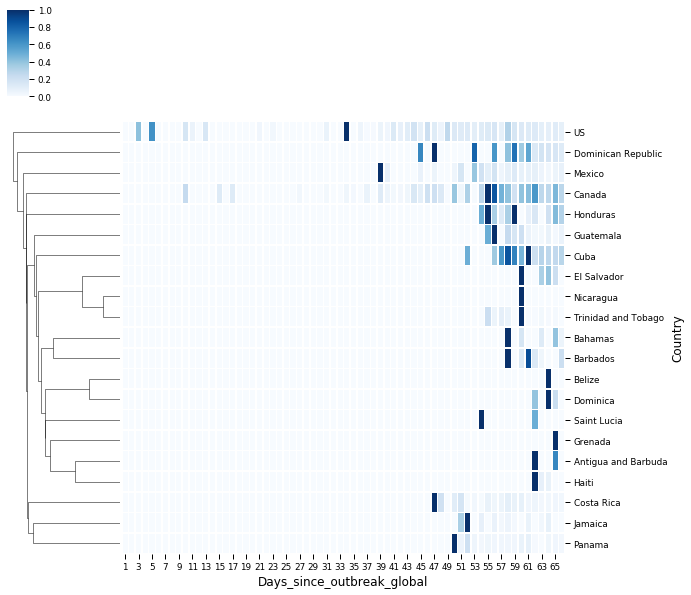

<Figure size 1800x576 with 0 Axes>

In [374]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5         6    7    8    9   \
Country                                                                        
Australia                   0.0  0.0  0.0  0.0  0.0  0.333333  0.0  0.0  3.0   
Fiji                        0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
New Zealand                 0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   

Days_since_outbreak_global        10  ...        57       58        59  \
Country                               ...                                
Australia                   0.166667  ...  2.097257  1.63591  3.348860   
Fiji                        0.000000  ...  0.000000  0.00000  0.000000   
New Zealand                 0.000000  ...  0.666667  0.40000  0.392857   

Days_since_outbreak_global        60        61        62        63        64  \
Country                                                                        
Australia                   3.175026  4.235216  1.695265  1.562388  

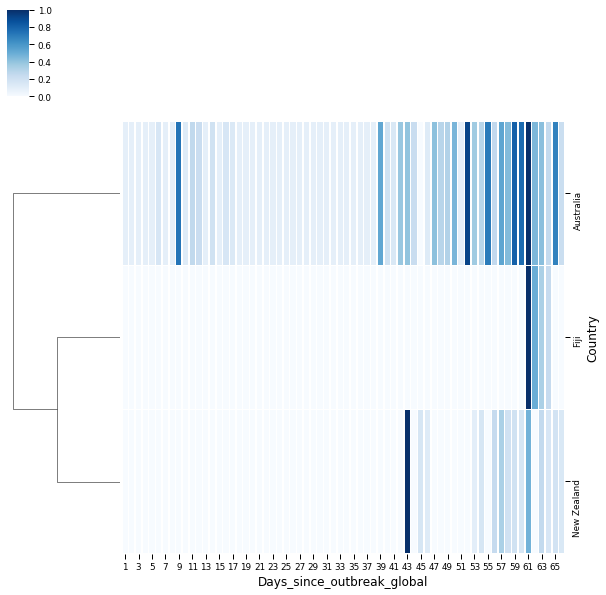

<Figure size 1800x576 with 0 Axes>

In [375]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Argentina                   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bolivia                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Brazil                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Chile                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Colombia                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...        57        58        59        60  \
Country                     ...                                           
Argentina                   ...  0.161765  0.227848  0.319588  0.234375   
Bolivia                     ...  0.090909  0.000000  0.250000  0.266667   
Brazil                      ...  0.158879  0.669355  0.276973  0.287516   
Chile                       ...  0.184080  0.000000  0.823529  0

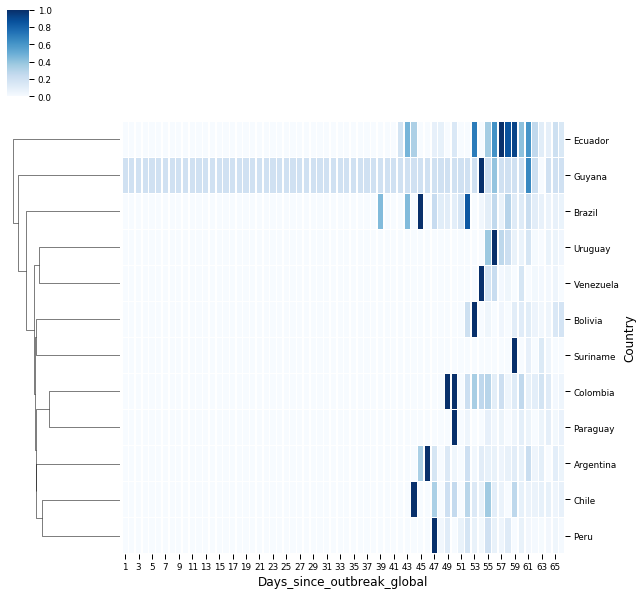

<Figure size 1800x576 with 0 Axes>

In [376]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

## Prediction - preperation

In [395]:
#Confirmed
split_date = '01-Apr-2019'
df_ml_confirmed = df
df_ml_confirmed['Confirmed_lag_7'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(7)
df_ml_confirmed['Days_since_outbreak_country'] = df_ml_confirmed.loc[(df_m.Confirmed > 0)].groupby(['Province_and_country','Lat','Long']).cumcount()+1
df_ml_confirmed = df_ml_confirmed.replace(np.nan, 0)
df_ml_confirmed = df_ml_confirmed[['Confirmed', 'Province_and_country', 'Days_since_outbreak_global', 'Date','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]

In [396]:
df_ml.to_csv('df_ml.CSV',sep=',')

### One Country Test

In [454]:
def create_x_y(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]
    if label:
        y = df[label]
        return X, y
    return X

In [617]:
Confirmed_test[['Confirmed', 'Confirmed_Prediction']]

,Confirmed,Confirmed_Prediction
Date,,
2020-03-22,113,62.964004
2020-03-23,133,32.083330
2020-03-24,164,-1434.518458
2020-03-25,188,-1429.123091
2020-03-26,224,-1980.699620
2020-03-27,267,-2850.545804


1448.1399397048801
38.054433903355864
27.606998804291386


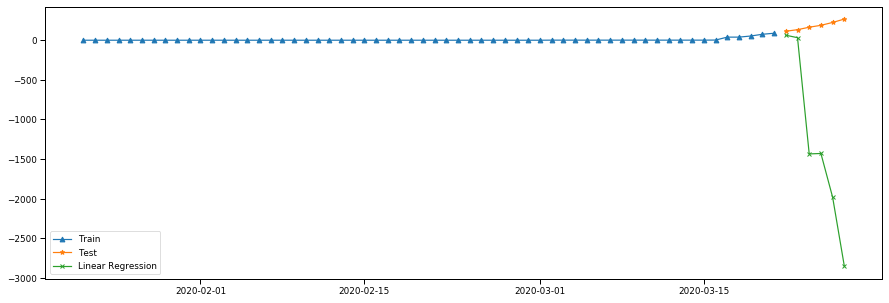

In [614]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

plt.rcParams["figure.figsize"] = (15,5)

split_date = '21-Mar-2020'

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Andorra")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

linear_regressor.fit(X_train, y_train)

Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Linear Regression', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))

3503.669054478227
59.191798878545896
0.39778698147329444


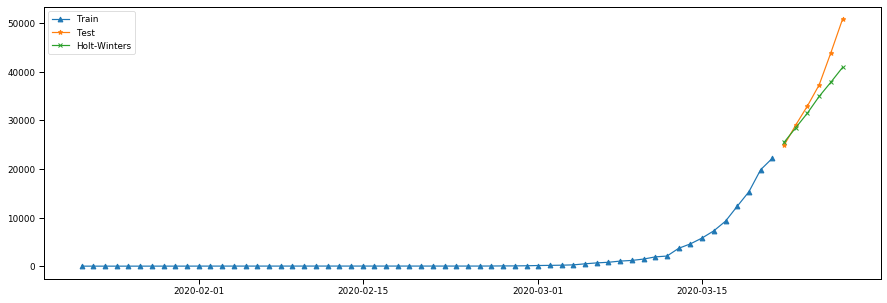

In [600]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

plt.rcParams["figure.figsize"] = (15,5)

split_date = '21-Mar-2020'

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))

In [591]:
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(seasonal=[6]) #[0,6,12]

In [592]:
edf = List['Confirmed']
ts = edf[:'21-Mar-2020'].copy()
ts_v = edf['22-Mar-2020':].copy()
ind = edf.index[-6:]  # this will select last 7 days indexes

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    print(j)
    try:
        cg = cfg_list[j]
        print(cg)
        t,d,s,p,b,r = cg
        train = edf[:'21-Mar-2020'].copy()
        test = edf['22-Mar-2020':'27-Mar-2020'].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(6)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        continue

Holt's Winter Model
0
['add', True, 'add', 6, True, True]
1
['add', True, 'add', 6, True, False]
2
['add', True, 'add', 6, False, True]
4950.806640611314
3
['add', True, 'add', 6, False, False]
4998.781659425887
4
['add', True, 'mul', 6, True, True]
5
['add', True, 'mul', 6, True, False]
6
['add', True, 'mul', 6, False, True]
7
['add', True, 'mul', 6, False, False]
8
['add', True, None, 6, True, True]
9
['add', True, None, 6, True, False]
10
['add', True, None, 6, False, True]
4948.02764952004
11
['add', True, None, 6, False, False]
4996.009349059657
12
['add', False, 'add', 6, True, True]
13
['add', False, 'add', 6, True, False]
14
['add', False, 'add', 6, False, True]
4950.806640611314
15
['add', False, 'add', 6, False, False]
4998.781659425887
16
['add', False, 'mul', 6, True, True]
17
['add', False, 'mul', 6, True, False]
18
['add', False, 'mul', 6, False, True]
19
['add', False, 'mul', 6, False, False]
20
['add', False, None, 6, True, True]
21
['add', False, None, 6, True, False]


In [594]:
def model_eval(y, predictions):

    # Import library for metrics
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Mean absolute error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Mean squared error (MSE)
    mse = mean_squared_error(y, predictions)


    # SMAPE is an alternative for MAPE when there are zeros in the testing data. It
    # scales the absolute percentage by the sum of forecast and observed values
    SMAPE = np.mean(np.abs((y - predictions) / ((y + predictions)/2))) * 100


    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y, predictions))

    # Calculate the Mean Absolute Percentage Error
    # y, predictions = check_array(y, predictions)
    MAPE = np.mean(np.abs((y - predictions) / y)) * 100

    # mean_forecast_error
    mfe = np.mean(y - predictions)

    # NMSE normalizes the obtained MSE after dividing it by the test variance. It
    # is a balanced error measure and is very effective in judging forecast
    # accuracy of a model.

    # normalised_mean_squared_error
    NMSE = mse / (np.sum((y - np.mean(y)) ** 2)/(len(y)-1))


    # theil_u_statistic
    # It is a normalized measure of total forecast error.
    error = y - predictions
    mfe = np.sqrt(np.mean(predictions**2))
    mse = np.sqrt(np.mean(y**2))
    rmse = np.sqrt(np.mean(error**2))
    theil_u_statistic =  rmse / (mfe*mse)


    # mean_absolute_scaled_error
    # This evaluation metric is used to over come some of the problems of MAPE and
    # is used to measure if the forecasting model is better than the naive model or
    # not.


    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('Root Mean Squared Error:', round(rmse, 3))
    print('Mean absolute percentage error:', round(MAPE, 3))
    print('Scaled Mean absolute percentage error:', round(SMAPE, 3))
    print('Mean forecast error:', round(mfe, 3))
    print('Normalised mean squared error:', round(NMSE, 3))
    print('Theil_u_statistic:', round(theil_u_statistic, 3))

In [595]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('01-Apr-2019'), end = pd.to_datetime('29-Feb-2020'))
pred_HW = fit2.forecast(6)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([List, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW))
print('-*-'*20)

# 15.570830579664698 ['add', True, 'add', 12, False, False]
# Mean Absolute Error: 10.456
# Mean Squared Error: 481.948
# Root Mean Squared Error: 15.571
# Mean absolute percentage error: 2.317
# Scaled Mean absolute percentage error: 2.273
# Mean forecast error: 483.689
# Normalised mean squared error: 0.04
# Theil_u_statistic: 0.0
# None
# -*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

4948.02764952004 ['add', True, None, 6, False, True]
Mean Absolute Error: 3524.167
Mean Squared Error: 37555.306
Root Mean Squared Error: 4948.028
Mean absolute percentage error: 8.127
Scaled Mean absolute percentage error: 8.709
Mean forecast error: 33627.819
Normalised mean squared error: 0.263
Theil_u_statistic: 0.0
None
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


3789.990747560827
61.56290074030647
0.6702981736615479


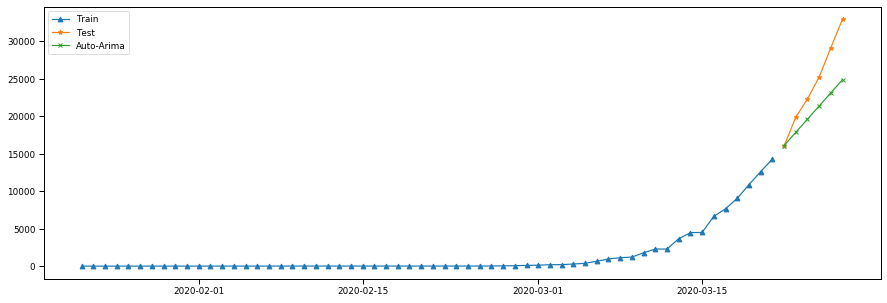

In [599]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

plt.rcParams["figure.figsize"] = (15,5)

split_date = '21-Mar-2020'

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "France")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='None', seasonal_periods=12, damped=True) #Tuned_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters optimized', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))

#['add', True, None, 6, False, True]
# t1,d1,s1,p1,b1,r1

2.3590036837281327
1.53590484201598
3.4328545973760876


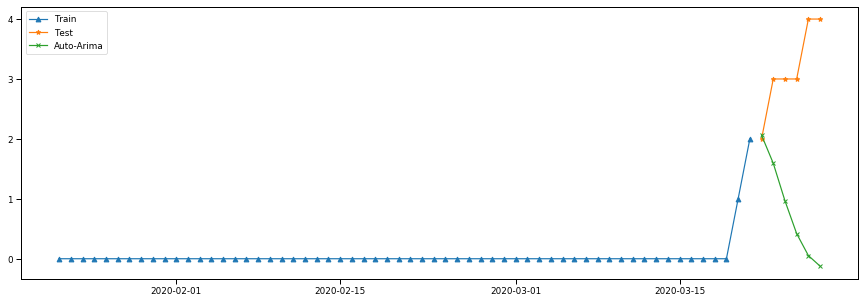

In [610]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

plt.rcParams["figure.figsize"] = (15,5)

split_date = '21-Mar-2020'

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Angola")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

stepwise_fit = auto_arima(train, error_action='ignore', trace=False,
                      suppress_warnings=True, maxiter=100,
                      seasonal=True, stepwise=True)  # set to stepwise

stepwise_fit.summary()

pred = pd.DataFrame(stepwise_fit.predict(n_periods=6), index= test.index)

pred.columns = ['Confirmed']

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Auto-Arima', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))

### All customers

In [655]:
df_ml_confirmed_var = pd.DataFrame(list(dict.fromkeys(df_ml_confirmed.Province_and_country)))
df_ml_confirmed_var.rename(columns={ df_ml_confirmed_var.columns[0]: "Value" }, inplace = True)
#df_ml_confirmed_var = df_ml_confirmed_var.loc[(df_ml_confirmed_var.Value == "Germany")]
#df_ml_confirmed_var = df_ml_confirmed_var.head(20)

#### Linear Regression

In [685]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

    linear_regressor.fit(X_train, y_train)

    Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Linear Regression"
    
    Train_and_Test_['MPE'] = (Confirmed_test['Confirmed'] - Confirmed_test['Confirmed_Prediction']) / Confirmed_test['Confirmed']

    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    

    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test = pd.concat(Train_and_Test_temp)


Finished!


In [689]:
Train_and_Test = Train_and_Test.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test.loc[Train_and_Test.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test.loc[Train_and_Test.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test.loc[Train_and_Test.SDMAE.notnull(), 'SDMAE']))
print(mean(Train_and_Test.loc[Train_and_Test.MPE.notnull(), 'MPE']))

25240.671195636332
158.87312924354558
2.865684586402052
-0.6230642379285338


#### Auto-ARIMA

In [611]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

MAE_temp = []
RMSE_temp = []
SDMAE_temp = []
Province_and_country_temp = []
Status_temp=[]

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    List.index = List['Date']
    
    train = List.loc[List.Date <= split_date]
    test = List.loc[List.Date > split_date]

    train = train.fillna(0)
    test = test.fillna(0)

    train = pd.DataFrame(train['Confirmed'])
    test = pd.DataFrame(test['Confirmed'])
    
    try:
        stepwise_fit = auto_arima(train, error_action='ignore', trace=False,
                              suppress_warnings=True, maxiter=100,
                              seasonal=True, stepwise=True)  # set to stepwise

        stepwise_fit.summary()

        pred = pd.DataFrame(stepwise_fit.predict(n_periods=6), index= test.index)

        pred.columns = ['Confirmed']

        Province_and_countrys = i
        Province_and_country_temp.append(Province_and_countrys)

        MAE_ = mean_absolute_error(y_pred=pred, y_true=test)
        MAE_temp.append(MAE_)

        RMSE_ = np.sqrt(mean_absolute_error(y_pred=pred, y_true=test))
        RMSE_temp.append(RMSE_)
        
        SDMAE_ = SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed)
        SDMAE_temp.append(SDMAE_)
        
        Status_ = "Run succesfully"
        Status_temp.append(Status_)
        
    except Exception as e:  
        Province_and_countrys = i
        Province_and_country_temp.append(Province_and_countrys)

        MAE_ = "Not run succesfully"
        MAE_temp.append(MAE_)

        RMSE_ = "Not run succesfully"
        RMSE_temp.append(RMSE_)
        
        SDMAE_ = "Not run succesfully"
        SDMAE_temp.append(SDMAE_)
        
        Status_= "Not run succesfully"
        Status_temp.append(Status_)
        
print("Finished!")

MAE = pd.DataFrame(MAE_temp)
RMSE = pd.DataFrame(RMSE_temp)
SDMAE = pd.DataFrame(SDMAE_temp)
Province_and_country = pd.DataFrame(Province_and_country_temp)
Status = pd.DataFrame(Status_temp)

Auto_ARIMA = pd.concat([MAE,RMSE,SDMAE, Province_and_country, Status], axis=1)
Auto_ARIMA.columns = ["MAE","RMSE", "SDMAE", "Province_and_country",  "Status"]
Auto_ARIMA.head()


Finished!


,MAE,RMSE,SDMAE,Province_and_country,Status
0,45.881611,6.773597,1.753615,Afghanistan,Run succesfully
1,41.200479,6.418760,1.170015,Albania,Run succesfully
2,84.810498,9.209262,1.156815,Algeria,Run succesfully
3,30.270314,5.501846,0.577066,Andorra,Run succesfully
4,2.359004,1.535905,3.432855,Angola,Run succesfully


In [612]:
Auto_ARIMA_success = Auto_ARIMA.replace([np.inf, -np.inf], np.nan)
print(mean(Auto_ARIMA_success.loc[Auto_ARIMA_success.MAE.notnull(), 'MAE']))
print(mean(Auto_ARIMA_success.loc[Auto_ARIMA_success.RMSE.notnull(), 'RMSE']))
print(mean(Auto_ARIMA_success.loc[Auto_ARIMA_success.SDMAE.notnull(), 'SDMAE']))

159.59376122965784
6.721935293126468
2.511633588537216
